data/df_stanford_real_features_leagues_[1729]_seasons_['15_16', '14_15', '13_14', '12_13', '11_12', '10_11', '09_10'].csv


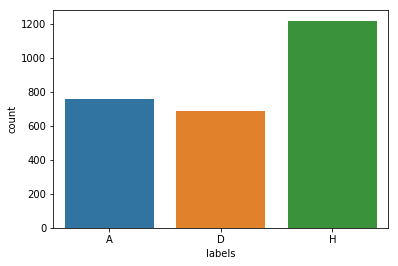

In [1]:
import pandas as pd
import numpy as np

import sklearn.preprocessing as preprocessing

import matplotlib.pyplot as plt
%matplotlib inline


import seaborn as sns
from sklearn.model_selection import train_test_split


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC

from sklearn.metrics import f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.multiclass import OneVsRestClassifier
from sklearn.preprocessing import label_binarize

## Variables

dataset = 'data/df_stanford_real_features_leagues_[21518, 1729]_seasons_[\'15_16\', \'14_15\', \'13_14\', \'12_13\', \'11_12\', \'10_11\', \'09_10\'].csv'
#dataset = 'data/df_stanford_fifa_features_leagues_[21518, 1729]_seasons_[\'15_16\', \'14_15\', \'13_14\', \'12_13\', \'11_12\', \'10_11\', \'09_10\'].csv'
#dataset = 'data/df_match_with_clusters.csv'
dataset = 'data/df_merge_dataset_stanford_real_fifa_leagues_[21518, 1729]_seasons_[\'15_16\', \'14_15\', \'13_14\', \'12_13\', \'11_12\', \'10_11\', \'09_10\'].csv'
dataset = 'data/df_stanford_real_features_leagues_[1729]_seasons_[\'15_16\', \'14_15\', \'13_14\', \'12_13\', \'11_12\', \'10_11\', \'09_10\'].csv'



print(dataset)
random_seed =1



## Reading and preparing datasets

df = pd.read_csv(dataset)
df.head()

df.columns

## Labels

labels = df['labels']
features = df.drop(columns = ['labels'])

# Balance of classes

sns.countplot(labels,label="Count")

plt.show()

In [2]:
seasons = ['2015/2016','2014/2015','2012/2013','2011/2012','2010/2011','2009/2010']
leagues_id = [21518,1729]
# seasons = ['2015/2016','2014/2015']
# leagues_id = [21518]

dataset = 'stanford_fifa_features'

In [3]:
def convert_to(df,type_to_convert, all_categorical = False,columns = 'None'):
 
    if all_categorical == True:
        categoric_types = df.select_dtypes(include=['object'])
        if categoric_types.columns.empty:
            print('No object types in the dataframe to be converted')
            return df
        else:
            if 'labels' in categoric_types.columns:
                categoric_types = list(categoric_types.columns)
                categoric_types.remove('labels')
                df[categoric_types] = df[categoric_types].astype('category')
                columns = categoric_types
        
    else:
        df[columns] = df[columns].astype('category')
        
        
    if type_to_convert == 'labelling':
        for column in columns:
            df[column] = df[column].cat.codes
    elif type_to_convert == 'onehot':
        for column in columns:
            df= pd.get_dummies(df, columns=[column])             
      
    return df

In [4]:
def convert_to(df,type_to_convert, all_categorical = False,columns = 'None'):
 
    if all_categorical == True:
        categoric_types = df.select_dtypes(include=['object','category']).columns
        if categoric_types.empty:
            print('No object types in the dataframe to be converted')
            return df
        else:
            if 'labels' in categoric_types:
                categoric_types.remove('labels')
            df[categoric_types] = df[categoric_types].astype('category')
            columns = categoric_types
        
    else:
        df[columns] = df[columns].astype('category')
        
        
    if type_to_convert == 'labelling':
        for column in columns:
            df[column] = df[column].cat.codes
    elif type_to_convert == 'onehot':
        for column in columns:
            print(columns)
            df= pd.get_dummies(df, columns=[column])             
      
    return df

In [6]:
def cross_val_evaluation(clf,dataset,leagues_id, seasons, location_to_file = 'data/'):
        
    accuracies_train = []
    accuracies_test = []
    
    
    for league_id_test in leagues_id:
        
         
        for season_test in seasons:
            train_dataset_chunks = []
            season_test = season_test.replace('/','_').replace('20','')

            test_data = pd.read_csv(location_to_file+f'df_{dataset}_leagues_{league_id_test}_seasons_{season_test}.csv')
               
                
            for season_train in seasons:
                                              
                season_train = season_train.replace('/','_').replace('20','')
                
                for league_id_train in leagues_id:
                    if season_test != season_train or league_id_test != league_id_train:

                        train_dataset_chunk = pd.read_csv(location_to_file+f'df_{dataset}_leagues_{league_id_train}_seasons_{season_train}.csv')

                        train_dataset_chunks.append(train_dataset_chunk)


            train_data = pd.concat(train_dataset_chunks)
            
            
            ## Remove Rows With Missing Values
            train_data.dropna(inplace=True)
            test_data.dropna(inplace=True)
            
            len_train_data = len(train_data)
            len_test_data = len(test_data)
            
            
            all_data = pd.concat([train_data, test_data], ignore_index=True)

            all_data = all_data.drop(columns= 'date')
            
            all_data_check_cat = all_data.copy()
            all_data_check_cat = all_data_check_cat.drop(columns='labels')
            categoric_types = all_data_check_cat.select_dtypes(include=['object'])

            if not categoric_types.columns.empty:
                all_data = convert_to(all_data,'onehot', all_categorical = True,columns ='None')
            
                if 'cluster_home' in all_data.columns:
                    all_data = convert_to(all_data,'onehot', all_categorical = False,columns =['cluster_home','cluster_away'])

            train_data = all_data.iloc[:len_train_data,:]
            test_data = all_data.iloc[len_train_data:,:]
            
            
            
            train_labels = train_data['labels']
            train_data = train_data.drop(columns='labels')
            test_labels = test_data['labels']
            test_data = test_data.drop(columns='labels')


            #Change types


            #features['stage'] = features['stage'].astype(int)  #uncomment when fifa players data has stage

            #SCALER
            scaler = preprocessing.MinMaxScaler()
#             scaler = preprocessing.StandardScaler()
#             scaler = preprocessing.RobustScaler()
#             scaler = preprocessing.PowerTransformer()

            numeric_types = train_data.select_dtypes(include=['float64','int'])


            train_data[numeric_types.columns] = scaler.fit_transform(train_data[numeric_types.columns])
            test_data[numeric_types.columns]  = scaler.transform(test_data[numeric_types.columns] )




            clf.fit(train_data, train_labels)

            acc_train = clf.score(train_data, train_labels)
            
            acc_test = clf.score(test_data, test_labels)
                
            print(len_train_data)
            print(len_test_data)
            print(f'Accuracy on training set: {acc_train}')
            print(f'Accuracy on testing set (df_{dataset}_leagues_{league_id_test}_seasons_{season_test}.csv): {acc_test}')

            accuracies_train.append(acc_train)
            accuracies_test.append(acc_test)
                                                     
                                                          
                                                          
    avg_train_acc = np.mean(accuracies_train)
    avg_test_acc = np.mean(accuracies_test)                                                 
                                                          
    print('.......................')
    print(f'Avg Accuracy on training set: {avg_train_acc}')
    print(f'Avg Accuracy on testing set: {avg_test_acc}')                                                




In [7]:
dataset = 'stanford_fifa_features'
cross_val_evaluation(SVC(),dataset,leagues_id, seasons, location_to_file = 'data/')

/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5406906544312968
Accuracy on testing set (df_stanford_fifa_features_leagues_21518_seasons_15_16.csv): 0.5421052631578948


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4142
379
Accuracy on training set: 0.5410429744084984
Accuracy on testing set (df_stanford_fifa_features_leagues_21518_seasons_14_15.csv): 0.5382585751978892


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5411736295580778
Accuracy on testing set (df_stanford_fifa_features_leagues_21518_seasons_12_13.csv): 0.5552631578947368


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5414151171214683
Accuracy on testing set (df_stanford_fifa_features_leagues_21518_seasons_11_12.csv): 0.5447368421052632


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5361023907268776
Accuracy on testing set (df_stanford_fifa_features_leagues_21518_seasons_10_11.csv): 0.6105263157894737


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5397247041777349
Accuracy on testing set (df_stanford_fifa_features_leagues_21518_seasons_09_10.csv): 0.5736842105263158


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4151
370
Accuracy on training set: 0.5492652372922188
Accuracy on testing set (df_stanford_fifa_features_leagues_1729_seasons_15_16.csv): 0.45135135135135135


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4169
352
Accuracy on training set: 0.5420964260014391
Accuracy on testing set (df_stanford_fifa_features_leagues_1729_seasons_14_15.csv): 0.53125


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5421395798116397
Accuracy on testing set (df_stanford_fifa_features_leagues_1729_seasons_12_13.csv): 0.5236842105263158


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5423810673750302
Accuracy on testing set (df_stanford_fifa_features_leagues_1729_seasons_11_12.csv): 0.5105263157894737


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.5450374305723256
Accuracy on testing set (df_stanford_fifa_features_leagues_1729_seasons_10_11.csv): 0.49736842105263157


/usr/local/lib/python3.7/site-packages/sklearn/preprocessing/data.py:323: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by MinMaxScaler.
  return self.partial_fit(X, y)
/usr/local/lib/python3.7/site-packages/sklearn/svm/base.py:196: FutureWarning: The default value of gamma will change from 'auto' to 'scale' in version 0.22 to account better for unscaled features. Set gamma explicitly to 'auto' or 'scale' to avoid this warning.
  "avoid this warning.", FutureWarning)


4141
380
Accuracy on training set: 0.536826853417049
Accuracy on testing set (df_stanford_fifa_features_leagues_1729_seasons_09_10.csv): 0.5789473684210527
.......................
Avg Accuracy on training set: 0.541491338741138
Avg Accuracy on testing set: 0.5381418359843665


In [ ]:
leagues_id

In [ ]:
seasons